In [15]:
# Import used libraries.
import torch
import pandas as pd
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import subprocess
import time
import csv

from dataset import OdometryDataset
from dataset import ToTensor

import model

In [11]:
#add path to folders to train on
folders=[]
folders.append("/aalto-cs/dataset-01/")
folders.append("/aalto-cs/dataset-03/")
folders.append("/aalto-cs/dataset-04/")
folders.append("/aalto-cs/dataset-05/")
folders.append("/kamppi/dataset-01/")
folders.append("/kamppi/dataset-02/")
folders.append("/kamppi/dataset-03/")
folders.append("/kamppi/dataset-05/")
folders.append("/kamppi/dataset-06/")
folders.append("/kamppi/dataset-08/")
folders.append("/kamppi/dataset-09/")
folders.append("/kamppi/dataset-10/")
folders.append("/kamppi/dataset-11/")
folders.append("/kamppi/dataset-12/")
folders.append("/tuas/dataset-01/")
folders.append("/tuas/dataset-02/")
folders.append("/outdoor-cs/dataset-01/")
folders.append("/outdoor-cs/dataset-02/")
folders.append("/outdoor-hk/dataset-01/")
folders.append("/static/dataset-01/")
folders.append("/static/dataset-02/")
folders.append("/static/dataset-03/")
folders.append("/swing/dataset-01/")

In [31]:
#manual labels for visualization

# standing=0
# walking =1
# staris=2
# escalators=3
# elevator=4
labs=[]
with open('labels.csv', 'rb') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
     for row in spamreader:
        labs.append([int(row[0]),int(row[1]),int(row[2]),float(row[3]),])

/aalto-cs/dataset-01/
148
148


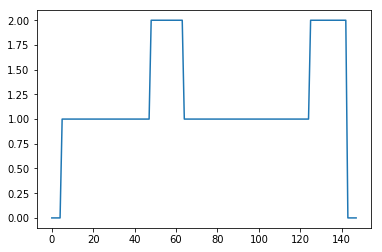

/aalto-cs/dataset-03/
49
49


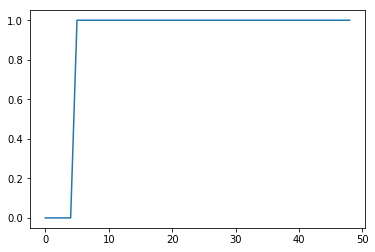

/aalto-cs/dataset-04/
143
143


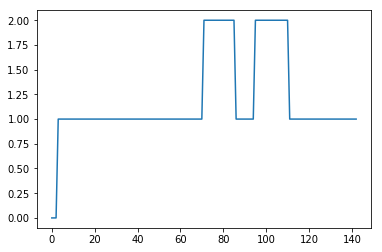

/aalto-cs/dataset-05/
154
154


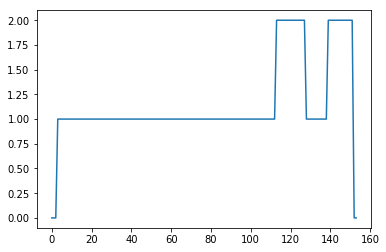

/kamppi/dataset-01/
256
256


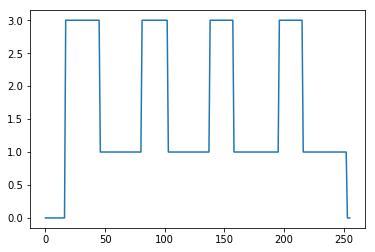

/kamppi/dataset-02/
195
195


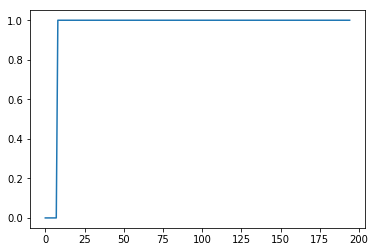

/kamppi/dataset-03/
144
144


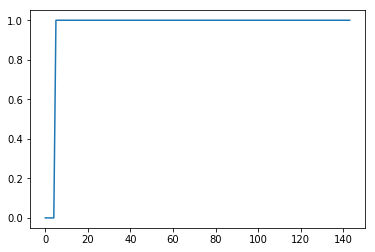

/kamppi/dataset-05/
158
158


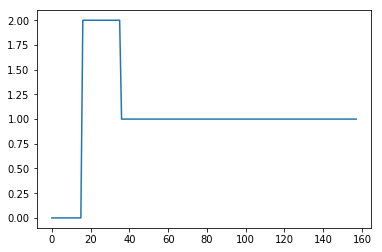

/kamppi/dataset-06/
272
272


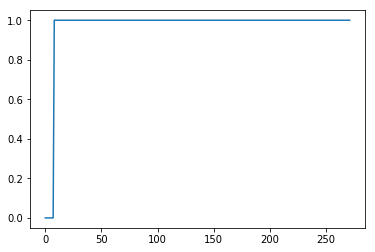

/kamppi/dataset-08/
104
104


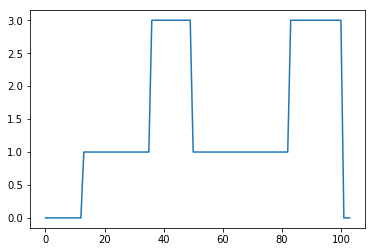

/kamppi/dataset-09/
93
93


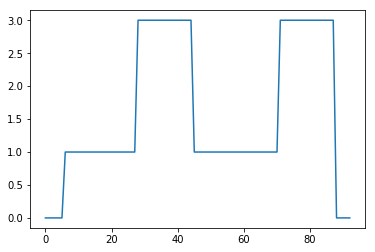

/kamppi/dataset-10/
120
120


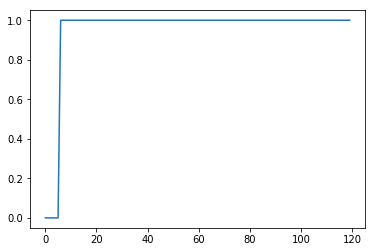

/kamppi/dataset-11/
203
203


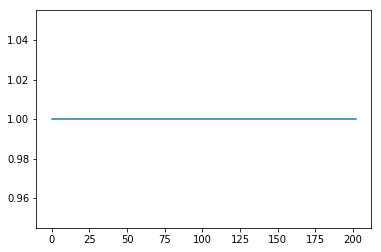

/kamppi/dataset-12/
111
111


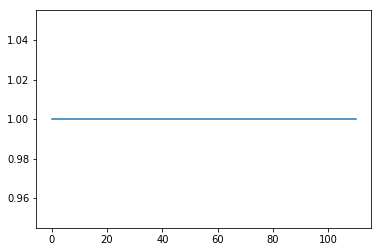

/tuas/dataset-01/
193
193


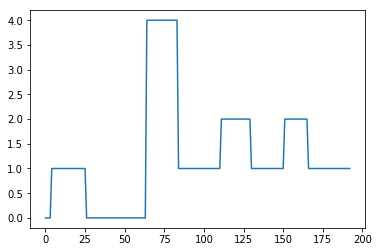

/tuas/dataset-02/
138
138


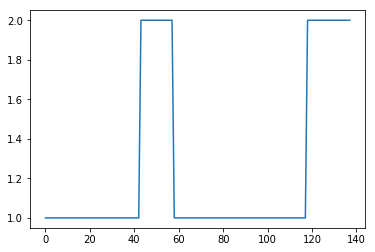

/outdoor-cs/dataset-01/
298
298


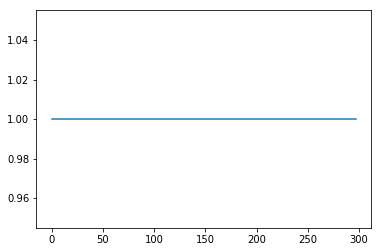

/outdoor-cs/dataset-02/
313
313


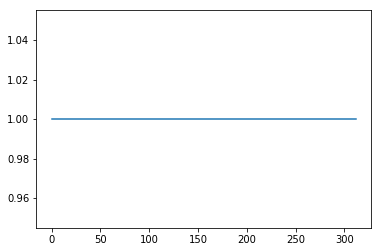

/outdoor-hk/dataset-01/
381
381


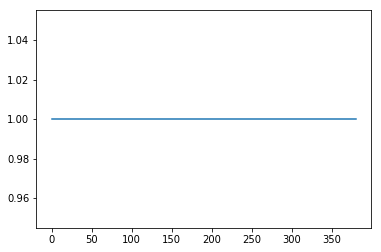

/static/dataset-01/
120
120


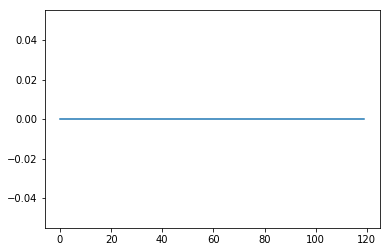

/static/dataset-02/
266
266


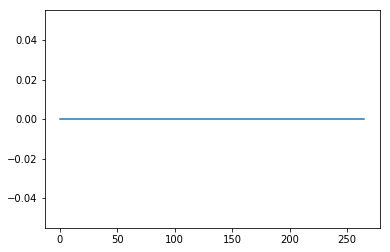

/static/dataset-03/
388
388


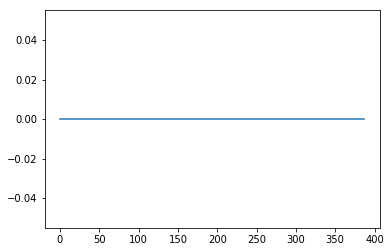

/swing/dataset-01/
174
174


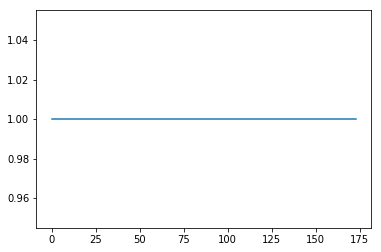

80
4421
4421
4432


In [13]:
ind=0
acc_lab=0
acc_dat=0
data_labels=[]
for folder in folders:
    print(folder)
    
    data=OdometryDataset("/l/datasets/arrgh/",[folder],transform=ToTensor())
    stay=True
    while labs[ind][3]==-2:
        ind=ind+1           
    stay=True
    dat=[]   
    dat.append([-1,0])
    while stay:
        tim=labs[ind][3]
        tim=np.round(np.floor(tim)*60+(tim-np.floor(tim))*100)
        data_length=(2+(data[len(data)]['time'])-data[0]['time'])[0]        
        if labs[ind][3]==-1:            
            stay=False
            tim=10000
        lab=labs[ind][2]
        dat.append([tim,lab])
        ind=ind+1   
    
    #print(data_length)
    label=[]
    start=data[0]['time']
    for i in range(0,len(data)):
        t=data[i]['time']-start
        for j in range(0,len(dat)-1):
            if t<dat[j+1][0] and t>dat[j][0]:
                label.append(dat[j+1][1])
    print(len(data))
    print(len(label))
    acc_dat=acc_dat+len(data)
    acc_lab=acc_lab+len(label)
    plt.plot(label)
    plt.show()
    data_labels.append(label)
print(ind)
print(acc_dat)
print(acc_lab)
data=OdometryDataset("/l/datasets/arrgh/",folders,transform=ToTensor())
print(len(data))   